# Bayesian fundamentals - model calibration and selection
Noah H. Paulson<sup>1</sup>\*, Marius Stan<sup>1</sup>

\* Corresponding author, npaulson@anl.gov

<sup>1</sup> Applied Materials Division, Argonne National Laboratory, Argonne, IL 60439

Presented for the Methods Series at NIST Gaithersburg, February 12, 2019


# Introduction

In this notebook we look into how Bayesian statistics can help us define models, calibrate them with data, and identify which models are most appropriate for the data. We begin by generating some synthetic data with noise according to a true model. Then, we look into the traditional machine learning approach for model calibration and selection. We continue with a short introduction to Bayesian inference, and discuss the development of analytical approaches to model selection and calibration. Finally, we look into non-analytical approaches to accomplish these tasks for our example and more complicated/challenging models.

First we load the necessary python packages and initialize variables.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.integrate import dblquad
from scipy.optimize import differential_evolution, minimize
sns.set(color_codes=True)

# Data generation

Let's define some notation:
* $x_i$, $t_i$, and $\varepsilon_i$ are the independent variable, dependent variable and error, respectively, for data point $i$.
* $\boldsymbol{\phi}\left(x_i\right)$ is a feature vector in the linear regression. For example, if we are interested in a quadratic model, $\boldsymbol{\phi}\left(x_i\right)={\left[1, x_i, {x_i}^2\right]}^T$
* $\boldsymbol{\Phi} = \left[\boldsymbol{\phi}\left(x_1\right), ..., \boldsymbol{\phi}\left(x_n\right)\right]$ is the array of $n$ feature vectors.
* $\textbf{t} = {\left[t_1, ..., t_n\right]}^T$ is the vector of $n$ responses.
* $\boldsymbol{\varepsilon} = {\left[\varepsilon_1, ..., \varepsilon_n\right]}^T$ is the vector of $n$ errors.

Now we define the model with which to generate data:
$$\textbf{t}=\boldsymbol{\Phi}^T\textbf{w}+\boldsymbol{\varepsilon}$$
where $\textbf{w} = \left[1, 1, 1\right].T$ is the vector of model parameters corresponding to our linear features, and $\boldsymbol{\varepsilon}\sim\mathcal{N}\left(\mu=0, \mathrm{precision}=\beta\right)$ for $\beta=400$ ($\sigma=0.05$).

In [10]:
np.random.seed(3)
param_true = np.array([1, 1, 1])
noise = 0.05

npts = 10
x_ = np.sort(ss.uniform.rvs(loc=0, scale=1, size=npts))
t_err = ss.norm.rvs(loc=0, scale=noise, size=npts)
t_ = param_true[0] + param_true[1]*x_ + param_true[2]*x_**2 + t_err

Let's plot the true model and the synthetic data points:

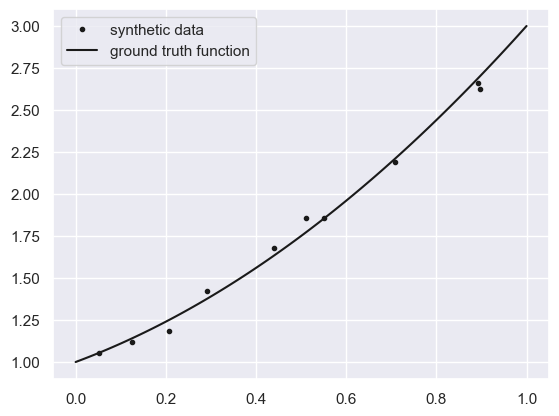

In [11]:
x_plt = np.linspace(0, 1, 100)
t_plt = param_true[0] + param_true[1]*x_plt + param_true[2]*x_plt**2
plt.plot(x_, t_, 'k.', label='synthetic data')
plt.plot(x_plt, t_plt, 'k-', label='ground truth function')
plt.legend()

# Model Calibration and Selection - Machine Learning 

The typical machine learning workflow is to select a model and optimize its parameters as guided by some cost function, such as the mean squared error (MSE). Unfortunately, it would be a mistake to use the cost function directly as a means to select between models. This is because these metrics (including the log-likelihood) will continue to improve with model complexity, with no indication of the overfitting that will eventually occur. Consequently, it is necessary to split the data into at least two sets, with one used to calibrate the model and the other reserved to evaluate its predictive ability for the purposes of selecting the best model.

In the example below, we fit linear, quadratic, and quintic polynomial models to the data using least squares linear regression (i.e. minimizing the MSE or equivalently maximizing the Gaussian log marginal likelihood). This is performed using three-fold cross-validation, wherein the dataset is divided into three parts, and each section is subsequently reserved for validating the model calibrated with the other 2/3rds of the data.

degree: 1 , MSE: 0.0029 , CV-MSE: 0.0122
degree: 2 , MSE: 0.0013 , CV-MSE: 0.0189
degree: 5 , MSE: 0.0007 , CV-MSE: 32.237


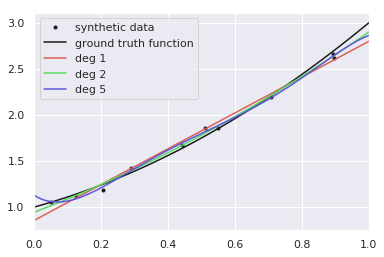

In [4]:
plt.figure()
plt.plot(x_, t_, 'k.', label='synthetic data')
plt.plot(x_plt, t_plt, 'k-', label='ground truth function')

X_ = x_[:, None]
X_plt = x_plt[:, None]

for deg, color in zip([1, 2, 5], sns.color_palette("hls", 3)):
    polynomial_features = PolynomialFeatures(degree=deg,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_, t_)
    
    # get squared errors using calibration data
    scores = (t_ - pipeline.predict(X_))**2

    plt.plot(X_plt, pipeline.predict(X_plt),
             color=color, label="deg " + str(deg))
    
    # Evaluate the models using crossvalidation
    cv_scores = cross_val_score(pipeline, X_, t_,
                                scoring="neg_mean_squared_error", cv=3)

    print('degree:', deg,
          ', MSE:', np.round(np.mean(scores), 4),
          ', CV-MSE:', -np.round(np.mean(cv_scores), 4))

plt.xlim([0, 1])
plt.legend()

Notice that as expected, the calibration MSE always decreases, while the CV-MSE decreases and then increases as model complexity become excessive and the predictive capacity is lowered.

# Bayesian inference

Bayes rule states that the distribution of the model parameters given the data, the posterior, is proportional to the distribution of the data around the model, the likelihood, times our assumed distribution of the model parameters before the observation of data, the prior. Bayes rule is given by,
$$p\left(\textbf{w}|\textbf{D}, M\right)=\frac{p\left(\textbf{D}|\textbf{w},M\right)p\left(\textbf{w}|M\right)}{p\left(\textbf{D}|M\right)}.$$
where $\textbf{D}=\{\textbf{X}, \textbf{t}\}$ and our choice of model is $M$. The denominator in Bayes rule is the marginal likelihood (sometimes the model evidence) and expresses the probability of the data given our model.

## Analytical Bayesian linear regression

The PRML text (Bishop 2006), provides a nice derivation for analytical Bayesian  linear regression with a Gaussian conjugate prior and posterior. As the derivation is rather complicated, we will present the results only.

First, we define the likelihood,
$$p\left(\textbf{t}|\textbf{w}\right)=\mathcal{N}\left(\textbf{t}|\boldsymbol{\Phi}^T\textbf{w},\beta^{-1}\right),$$
and the prior, 
$$p\left(\textbf{w}\right)=\mathcal{N}\left(\textbf{w}|\textbf{0},\alpha^{-1}\textbf{I}\right),$$
where we assume a zero-centered multivariate Gaussian distribution with a diagonal covariance matrix defined by a precision parameter $\alpha$.

This combination of Gaussian prior and likelihood allows us to derive a conjugate Gaussian posterior,

$$p\left(\textbf{w}|\textbf{t}\right)\sim\left(\textbf{w}|\textbf{m}_N,\textbf{s}_N\right)$$
$$\textbf{m}_N=\beta \, \textbf{S}_N \boldsymbol{\Phi}^T \textbf{t}, \quad {\textbf{S}_N}^{-1}=\alpha\,\textbf{I}+\beta\, \boldsymbol{\Phi}^T \boldsymbol{\Phi}$$

Now we'll use these equations directly to evaluate the posterior given the data we generated earlier. We'll use a standard deviation of 1 for the prior distribution ($\alpha=1$), and give it the correct $\beta$.

In [5]:
def coef_pos(data_mat, t_mat, cov_pri, alpha, beta):

    datsqr = np.einsum('ji,jk', data_mat, data_mat)
    # cov_pos_inv: matrix of second derivatives of the error funtion (Eq. 3.83)
    cov_pos_inv = alpha*cov_pri + beta*datsqr
    # cov_pos: posterior covaraince matrix for coefficients
    cov_pos = np.linalg.inv(cov_pos_inv)
    # mean_pos: mean set of coefficients of posteriaor
    mean_pos = beta*np.einsum('ij,kj,k', cov_pos, data_mat, t_mat)

    return mean_pos, cov_pos, cov_pos_inv


def get_phi(x, deg):
    """create polynomial feature vectors for original feature
    list x"""
    phi = np.ones(np.hstack([x.shape, deg+1]).astype('int'))

    for ii in range(1, deg+1):
        phi[..., ii] = x**ii
    return phi

In [6]:
# alpha is the precision parameter (1/variance) for the prior
alpha = 1/(1**2)
# beta is the precision parameter for the likelihood
beta = 1./(noise**2)

deg = 1
color = sns.color_palette("hls", 3)[0]

cov_pri = np.identity(deg+1)
data_mat = get_phi(x_, deg)
mean_pos, cov_pos, cov_pos_inv = coef_pos(
    data_mat, t_, cov_pri, alpha, beta)
    
param_samples = ss.multivariate_normal.rvs(mean_pos, cov_pos, size=1000)

Text(0, 0.5, '$w_1$')

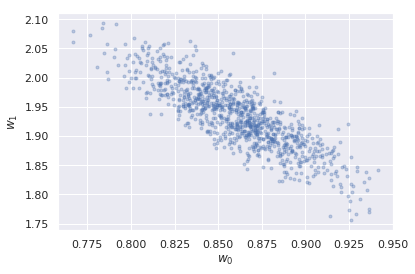

In [7]:
plt.figure()
plt.plot()
plt.plot(param_samples[:, 0], param_samples[:, 1], 'b.', alpha=0.3)
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$")

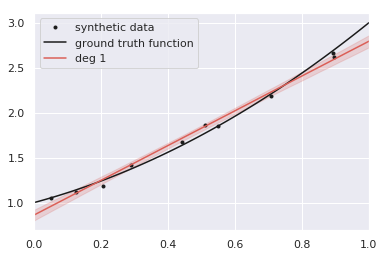

In [8]:
plt.figure()
plt.plot(x_, t_, 'k.', label='synthetic data')
plt.plot(x_plt, t_plt, 'k-', label='ground truth function')
predictions = np.dot(get_phi(x_plt, deg), param_samples.T)
low, mid, high = np.percentile(predictions, [2.5, 50., 97.5], axis=1)
plt.plot(x_plt, mid, color=color, label="deg " + str(deg))
plt.fill_between(x_plt, low, high, color=color, alpha=0.2)
    
plt.xlim([0, 1])
plt.legend()

## Bayesian model selection

The denominatory of Bayes' Theorem, $p\left(\textbf{D}|M\right)$, or the marginal likelihood, provides an effective means to select between two models in a Bayesian fashon. The marginal likelihood may be obtained by integrating over the parameters for the product of the likelihood and prior,
$$p\left(\textbf{D}|M\right) = \int p\left(\textbf{D}|\textbf{w},M\right)p\left(\textbf{w}\right|M)d\textbf{w}.$$
Feroz and Hobson (Feroz, 2008) give a consise explanation for the effectivness of the marginal likelihood for model selection: *"As the average of the likelihood over the prior, the evidence is larger for a model if more of its parameter space is likely, and smaller for a model with large areas in its parameter space having low likelihood values, even if the likelihood function is very highly peaked. Thus, the evidence automatically implements Occam’s razor: a simpler theory with compact parameter space will have a larger evidence than a more complicated one, unless the latter is significantly better at explaining the data."*

In practice, to select between models $M_a$ and $M_b$ we need to compare $p\left(M_a|\textbf{D}\right)$ and $p\left(M_b|\textbf{D}\right)$. This is easily achieved through another application of Bayes Theorem,
$$p\left(M|\textbf{D}\right)=\frac{p\left(\textbf{D}|M\right) p\left(M\right)}{p\left(\textbf{D}\right)}.$$
We can then compare two models as follows,
$$K=\frac{p\left(M_a|\textbf{D}\right)}{p\left(M_b|\textbf{D}\right)}=\frac{p\left(\textbf{D}|M_a\right) p\left(M_a\right)}{p\left(\textbf{D}|M_b\right) p\left(M_b\right)},$$
where $K$ is the Bayes factor. If we have no reason to prefer one model versus another before the observation of data this is simply the ratio of the marginal likelihoods.

The following table (Kass and Raftery, 1995) provides a qualitative guide for the degree of preference of one model over another based on Bayes Factor:

|K|Strength of Evidence|
|---|---|
|1 to 3|not worth more than a bare mention|
|3 to 20|postive|
|20 to 150|strong|
|>150|very strong|

Since we mostly deal with log-marginal likelihoods, the Bayes Factor can be reinterpreted as the difference between the log-marginal likelihoods of two models:

|ln(K)|Strength of Evidence|
|---|---|
|0 to 1.1|not worth more than a bare mention|
|1.1 to 3.0|postive|
|3.0 to 5.0|strong|
|>5.0|very strong|

Let's return to our example problem and obtain an analytical expression for the marginal likelihood for a linear model. Through a derivation given in PRML, the log marginal likelihood is given as
$$\mathrm{ln}\left(\textbf{t}\right)=\frac{M}{2}\mathrm{ln}\,\alpha+\frac{N}{2}\mathrm{ln}\,\beta-E\left(\textbf{m}_N\right)-\frac{1}{2}\mathrm{ln}|{\textbf{S}_N}^{-1}|-\frac{N}{2}\mathrm{ln}\left(2\pi\right).$$

We will now use this result, along with the previous form of the posterior to perform analytical Bayesian inference on the data for linear, quadratic, and quintic polynomials, and will use Bayes factors to perform model selection.

In [9]:
def err_f(x_vec, t_vec, mean_pos, deg):
    err = 0
    for ii in range(x_vec.size):
        phi = get_phi(x_vec[ii], deg)
        err += (t_vec[ii] - np.einsum('i,i', mean_pos, phi))**2
    return err


def evidence(x_vec, t_vec, alpha, beta, deg, mean_pos, cov_pos_inv):

    err = err_f(x_vec, t_vec, mean_pos, deg)
    exp_mn = (beta/2.)*err+(alpha/2.)*np.einsum('i,i', mean_pos, mean_pos)
    ev = (deg/2.)*np.log(alpha) +\
         (x_vec.size/2.)*np.log(beta) -\
        exp_mn -\
         (1/2.)*np.log(np.linalg.det(cov_pos_inv)) -\
         (x_vec.size/2.)*np.log(2*np.pi)

    return ev

degree: 1 , log marginal likelihood: 5.742
degree: 2 , log marginal likelihood: 8.094
degree: 5 , log marginal likelihood: 6.569


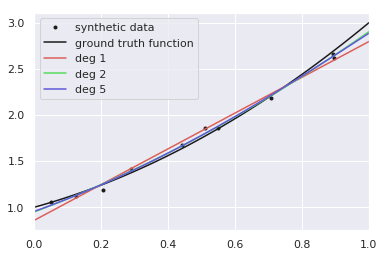

In [10]:
plt.figure()
plt.plot(x_, t_, 'k.', label='synthetic data')
plt.plot(x_plt, t_plt, 'k-', label='ground truth function')

# alpha is the precision parameter (1/variance) for the prior
alpha = 1/(1**2)
# beta is the precision parameter for the likelihood
beta = 1./(noise**2)

for deg, color in zip([1, 2, 5], sns.color_palette("hls", 3)):

    cov_pri = np.identity(deg+1)
    data_mat = get_phi(x_, deg)
    mean_pos, cov_pos, cov_pos_inv = coef_pos(
        data_mat, t_, cov_pri, alpha, beta)
    ev = evidence(x_, t_, alpha, beta, deg, mean_pos, cov_pos_inv)

    print('degree:', deg,
          ', log marginal likelihood:', np.round(ev, 3))

    pred = np.dot(get_phi(x_plt, deg), mean_pos)
    plt.plot(x_plt, pred, color=color, label="deg " + str(deg))
    
plt.xlim([0, 1])
plt.legend()

## Non-analytical Bayesian inference

For many models it may not possible (or advisable) to analytically evaluate the posterior distribution. This may be due to a number of factors, including large numbers of latent variables, complexity of the posterior or the lack of analytical solutions. In these cases, we turn to non-analytical techniques. These can be broadly divided into the categories of **approximate inference** and **Monte Carlo** techniques.

In **approximate Bayesian inference**, we make assumptions about the form of the posterior distribution that make its evaluation more approachable. One popular approach is variational Bayesian inference, where we pick an analytical form of the posterior (e.g. a multivariate Gaussian distribution) and employ some metric to find the closest parametrization to the true posterior (the Expectation Lower BOund, or ELBO, is most commonly used). Approximate Bayesian inference is well suited to the most computationally unwieldy problems from a dimensionality or data quantity perspective.

**Monte Carlo** algorithms describe sampling from the posterior distribution. In contrast to approximate Bayesian inference, most of these techniques would perfectly replicate the posterior with an infinite number of samples. Markov chain Monte Carlo (MCMC) sampling schemes are the most well-known sampling techniques, but are by no means the only option. Efficent numerical sampling of the posterior distribution is possible because the marginal likelihood, $p\left(\textbf{D}|M\right)$, is constant with respect to $\textbf{w}$. Therefore the posterior is proportional to the likelihood times the prior,
$$p\left(\textbf{w}|\textbf{D}, M\right) \propto p\left(\textbf{D}|\textbf{w},M\right)p\left(\textbf{w}|M\right).$$

### Rejection sampling

As an introduction to Monte Carlo methods we describe rejection sampling, one of the simplest algorithms for sampling models with continuous variables. Using the notation from (Bishop, 2006), we might want to sample a distribution $p\left(z\right)$, however we are only able to evaluate $p$ up to a normalizing constant,
$$p\left(z\right)=\frac{1}{Z_p}\tilde{p}\left(z\right),$$
where $\tilde{p}\left(z\right)$ is the likelihood times the prior, and $Z_p$ is the marginal likelihood. To sample this distribution we follow these steps:
1. select a proposal distribution, $q\left(z\right)$, and a constant $k$ such that $kq\left(z\right)\geq\tilde{p}\left(z\right)\:\forall\:z$.
2. randomly sample $z_0$ from $q\left(z\right)$
3. randomly sample $u_0 \sim \mathcal{U}\left(\left[0,kq\left(z\right)\right]\right)$
4. accept sample if $u_0 \leq \tilde{p}\left(z_0\right)$
5. repeat steps 2 through 4 until convergence

![Figure 11.4, (Bishop, 2006)](rejection_sampling_fig.png)

Now we will demonstrate rejection sampling for the linear model from the previous example. First we define the likelihood and prior distribution for our problem.

In [11]:
def lin_likelihood(param):
    prob = ss.norm.logpdf(
        t_,
        loc=param[0]+param[1]*x_,
        scale=noise).sum()
    return prob


def lin_prior(param):
    mean = np.zeros((2,))
    cov = np.identity(2)/alpha
    return ss.multivariate_normal.logpdf(param, mean, cov)


def lin_posterior(param):
    return lin_likelihood(param) + lin_prior(param)

Now we need to identify a proposal distribution. If we assume unimodal posterior, the maximum a posteriori (MAP) can be used as a scaling factor. For fun let's compute the maximum likelihood estimate (MLE) in addition the MAP.

In [12]:
def lin_likelihood_opt(param):
    return -lin_likelihood(param)


def lin_posterior_opt(param):
    return -lin_posterior(param)

MLE = minimize(lin_posterior_opt, (0, 0)).x
res = minimize(lin_likelihood_opt, (0, 0))
MAP_val = np.exp(-res.fun)
MAP = res.x
print('MLE:', np.round(MLE, 3), '\nMAP:', np.round(MAP, 3))

MLE: [0.858 1.939] 
MAP: [0.856 1.943]


Interestingly, the MLE and MAP parameter sets are very similar for this problem.

Now we can define the proposal distribution as a multivariate Gaussian centered at the MAP. To keep things simple, we define a diagonal covariance matrix with non-zero elements defined by a single variance parameter. The proposal distribution is scaled so that its maximum equals the MAP. It only remains to select a variance parameter such that the proposal distribution is greater than the unnormalized posterior for all parameter sets.

In [13]:
n_samp = np.int(1E5)
cov = 0.01*np.identity(2)
proposal_max = ss.multivariate_normal.pdf(MAP, MAP, cov)
proposal_samples = ss.multivariate_normal.rvs(MAP, cov, size=n_samp)
proposal_values = (MAP_val/proposal_max)*ss.multivariate_normal.pdf(proposal_samples, MAP, cov)
posterior_values = np.array([np.exp(lin_posterior(samp)) for samp in proposal_samples])

n_invalid = np.sum(posterior_values>proposal_values)
if n_invalid > 0:
    print(n_invalid, 'posterior values were greater than the proposal')

posterior_samples = proposal_samples[np.random.uniform(size=n_samp)*proposal_values <= posterior_values, :]
posterior_values = proposal_values[np.random.uniform(size=n_samp)*proposal_values <= posterior_values]
print('acceptance fraction:', posterior_samples.shape[0]/n_samp)

acceptance fraction: 0.00131


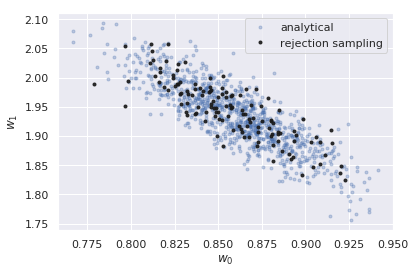

In [14]:
plt.figure()
plt.plot()
plt.plot(param_samples[:, 0], param_samples[:, 1], 'b.', alpha=0.3, label='analytical')
plt.plot(posterior_samples[:, 0], posterior_samples[:, 1], 'k.', alpha=0.9, label='rejection sampling')
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$")
plt.legend()

Since we are only drawing samples from the posterior distribution, we no longer have access to the marginal likelihood. In this simple problem we can numerically integrate the product of the likelihood and the prior.

In [15]:
res = dblquad(lambda a, b: np.exp(lin_posterior([a, b])), 0, 5, 0, 5)
print('marginal likelihood:', np.round(np.log(res[0]), 3))

marginal likelihood: 5.742


We get the same marginal likelihood from this problem as from the analytical approach. In many cases, however, it is far more difficult to compute the marginal likelihood using standard numerical integration approaches due to the complexity and dimensionality of the posterior. The most common Monte Carlo approach to solving this problem (and in tackling multimodal distributions) is thermodynamic integration. Unfortunately, thermodynamic integration requires multiple converged MC runs. For this reason, we turn to cutting-edge algorithms, such as nested sampling, that are computationally efficient and provide robust estimates of the posterior distribution and the marginal likelihood.

### Nested samping

Nested sampling works on the concept that the multidimensional integral of the likelihood and the prior over all parameter space can be transformed to a one-dimensional integral. First, we can define the volume of the prior, $X$, bounded by some iso-likelihood contour,
$$X\left(\lambda\right)=\int_{L\left(\boldsymbol{\theta}\right)>\lambda}\pi\left(\boldsymbol{\theta}\right)d^D\boldsymbol{\theta},$$
where $\lambda$ is the likelihood level. In the left figure below, regions of parameter space are bounded by such iso-likelihood countours at levels $\mathcal{L}_1$ through $\mathcal{L}_4$.

![nested sampling](nested_sampling_fig.png)

In the figure to the right, these likelihood contours are plotted as a function of the volume of the prior distribution they contain. In moving from lowest to highest likelihood, the prior volume shrinks from one (the total volume under the prior distribution) to zero. The area under the curve is equal to the marginal likelihood as expressed by
$$\mathcal{Z}=\int_0^1 L\left(X\right)dX.$$

In practice, evaluating the marginal likelihood in this fashion requires the estimation of the prior volumes enclosed by likelihood contours. The basic algorithm proceeds as follows:
1. draw $N$ live samples from the prior $p_i\left(\boldsymbol{\theta}\right)$
2. remove sample with smallest likelihood from live set.
3. replace with new sample from prior subject to $L_i>L_{i-1}$
4. corrosponding updated prior volume is random variable given by $X_i=t_i X_{i-1}$, where $t \sim N t^{N-1}$
5. repeat steps 2 - 4 until $\Delta\mathcal{Z}_i=L_{max}X_i$ (an estimate of the remaining posterior volume) is below some specified threshold.

After the stoppage criteria is satisfied, all discarded samples are used for inference.

Multinest extends beyond the basic nested sampling by including strategies to more efficiently pick samples according to $L_i>L_{i-1}$ (especially for multimodal distributions or distributions with significant degeneracies) and to provide robust estimates of the uncertainty in the marginal likelihood.